# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-rw-r-- 1 1000 1002 1.2K Feb  5 08:39 README.md


In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_242
Branch 
Compiled by user  on 2019-08-27T21:31:02Z
Revision 
Url 
Type --help for more information.


## Запуск spark

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F



spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
ls /workspace

apache_spark/        __MACOSX/                        spark_sql/
data/                on_restart.sh*                   wget-log
data_movie_lens.zip  README.md                        wget-log.1
docker/              run_jupyter.sh*                  wget-log.2
hadoop_map_reduce/   spark-2.4.4-bin-hadoop2.6.tgz    wget-log.3
intro/               spark-2.4.4-bin-hadoop2.6.tgz.1


In [5]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [6]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [7]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [9]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [10]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [11]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [12]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [13]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [14]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [15]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=143567, mean_rating=5.0, ratings_count=1, movieId=143567, title='Mining for Ruby (2014)', genres='(no genres listed)'),
 Row(movie_id=135232, mean_rating=5.0, ratings_count=1, movieId=135232, title='Jailbait Babysitter (1977)', genres='Comedy'),
 Row(movie_id=175827, mean_rating=5.0, ratings_count=1, movieId=175827, title='Cedric the Entertainer: Taking You Higher (2006)', genres='Comedy'),
 Row(movie_id=138196, mean_rating=5.0, ratings_count=1, movieId=138196, title='Pretty Rosebud (2014)', genres='(no genres listed)'),
 Row(movie_id=178247, mean_rating=5.0, ratings_count=1, movieId=178247, title='Message From Hiroshima (2015)', genres='Documentary'),
 Row(movie_id=162364, mean_rating=5.0, ratings_count=1, movieId=162364, title='The Valley of Light (2007)', genres='Drama|Romance'),
 Row(movie_id=118995, mean_rating=5.0, ratings_count=1, movieId=118995, title='The Two Firefighters (1968)', genres='Comedy'),
 Row(movie_id=125197, mean_rating=5.0, ratings_count=1, movieId=1

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [16]:
%%time

movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

CPU times: user 522 ms, sys: 67.2 ms, total: 589 ms
Wall time: 2min 56s


In [17]:
movies_frequency_pdf.head(10)

movie_id  count  movieId                                      title  \
0       356  81491      356                        Forrest Gump (1994)   
1       318  81482      318           Shawshank Redemption, The (1994)   
2       296  79672      296                        Pulp Fiction (1994)   
3       593  74127      593           Silence of the Lambs, The (1991)   
4      2571  72674     2571                         Matrix, The (1999)   
5       260  68717      260  Star Wars: Episode IV - A New Hope (1977)   
6       480  64144      480                       Jurassic Park (1993)   
7       527  60411      527                    Schindler's List (1993)   
8       110  59184      110                          Braveheart (1995)   
9      2959  58773     2959                          Fight Club (1999)   

                             genres  
0          Comedy|Drama|Romance|War  
1                       Crime|Drama  
2       Comedy|Crime|Drama|Thriller  
3             Crime|Horror|Thriller  
4            Action|Sci-Fi|Thriller  
5           Action|Adventure|Sci-Fi  
6  Action|Adventure|Sci-Fi|Thriller  
7                         Drama|War  
8                  Action|Drama|War  
9       Action|Crime|Drama|Thriller

---
## SQL

In [18]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [19]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [20]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#131]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#134L, title#131]
+- Sort [count(1)#134L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#134L, first(title#31, false) AS title#131]
      +- Filter title#31 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#30 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#30,title#31,genres#32] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [21]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [22]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .sort(F.col('year')) \
    .toPandas()

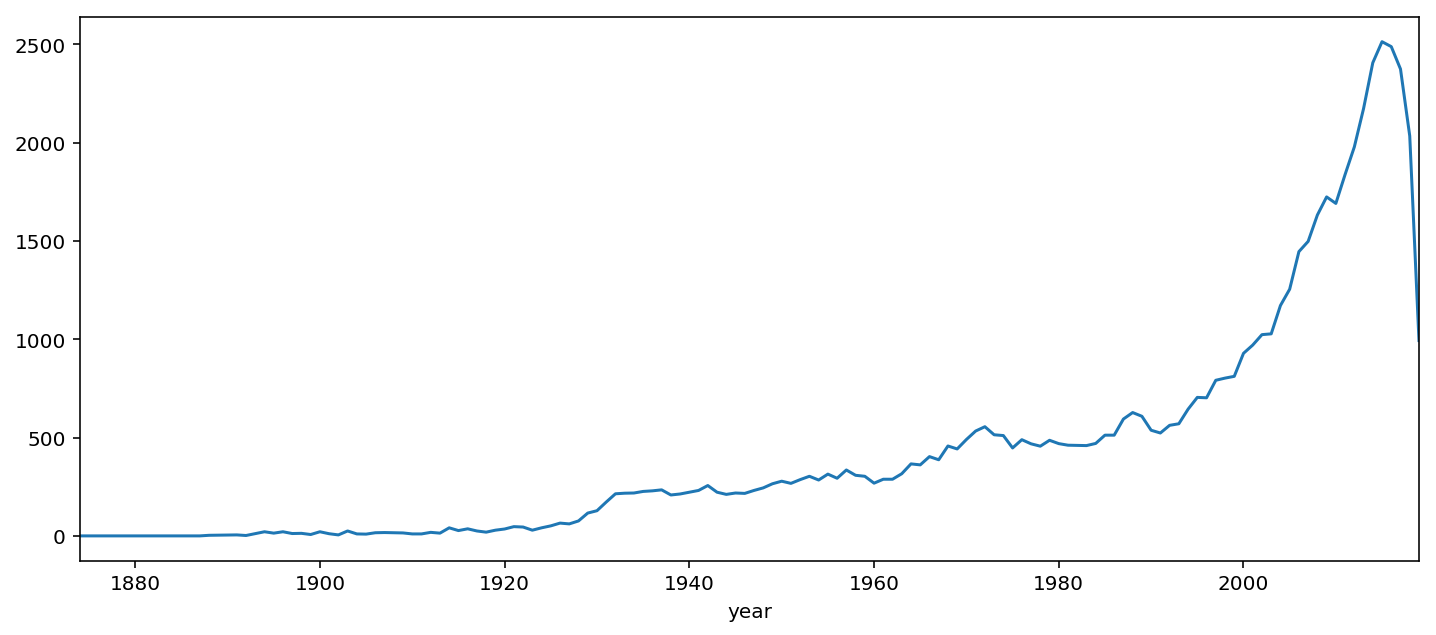

In [23]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [24]:
user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

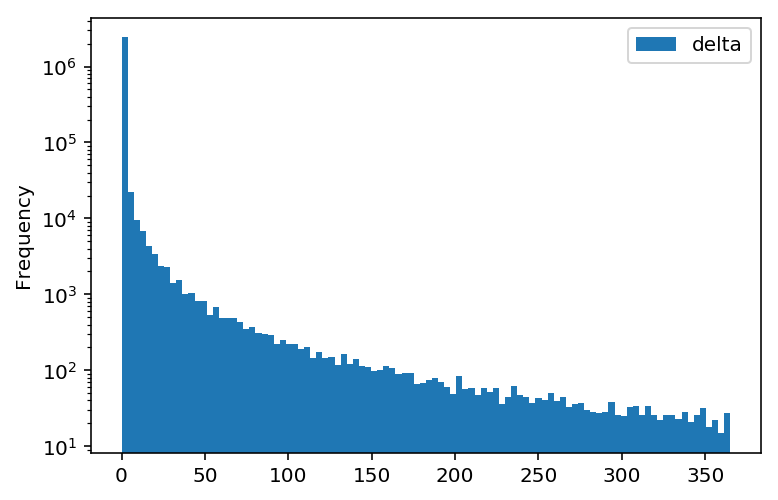

In [25]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

In [26]:
ratings_df.persist()

DataFrame[movie_id: bigint, rating: double, timestamp: bigint, user_id: bigint]

In [27]:
movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

movies_df = movies_df.withColumnRenamed('movieId', 'movie_id')
movies_df.limit(5).toPandas()

movie_id                               title  \
0         1                    Toy Story (1995)   
1         2                      Jumanji (1995)   
2         3             Grumpier Old Men (1995)   
3         4            Waiting to Exhale (1995)   
4         5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [28]:
%%time

users = ratings_df \
  .select('user_id') \
  .distinct()

users_rand_10k = users \
  .withColumn('rand', F.rand(seed=42)) \
  .sort('rand') \
  .select('user_id') \
  .limit(10000) \
  .sort('user_id')

users_rand_10k.persist()
users_rand_10k.limit(5).toPandas().head(5)

CPU times: user 43.9 ms, sys: 12.2 ms, total: 56.1 ms
Wall time: 3min


user_id
0       30
1       37
2       41
3       67
4       76

In [29]:
%%time

ratings_df_short = ratings_df.join(users_rand_10k, 'user_id')
ratings_df_short.persist()
ratings_df_short.count()

CPU times: user 0 ns, sys: 9.53 ms, total: 9.53 ms
Wall time: 2.57 s


1566540

In [30]:
ratings_df_short.limit(5).toPandas()

user_id  movie_id  rating   timestamp
0       30       377     1.5  1488511608
1       30       410     4.5  1488511992
2       30       500     4.0  1488511221
3       30      1080     4.0  1488511559
4       30      1136     4.5  1488510932

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [31]:
# посчитать похожесть множеств (jacard similarity и cosine similarity) по атрибуту intersection_attribute
# считается для всех пар (left_attribute, right_attrirubte)   
# возващает [(left_attribute, right_attribute, jaccard_sim, cos_sim)]
def compute_similarity(intersection_attribute, left_df, left_attribute, right_df, right_attribute):
    assert left_attribute != right_attribute
    left = left_df.select(left_attribute, intersection_attribute).distinct()
    right = right_df.select(right_attribute, intersection_attribute).distinct()
    
    left.persist()
    right.persist()
    
    intersection = left \
      .join(right, intersection_attribute) \
      .groupby([left_attribute, right_attribute]) \
      .count() \
      .withColumnRenamed('count', 'intersection')
    
    left_counts  =  left.groupby( left_attribute).count().withColumnRenamed('count', 'left_count')
    right_counts = right.groupby(right_attribute).count().withColumnRenamed('count', 'right_count')
    
    similarity = intersection \
             .join(left_counts, left_attribute) \
             .join(right_counts, right_attribute) \
             .withColumn('jaccard_sim', F.col('intersection') / 
                                             (F.col('left_count') + F.col('right_count') - F.col('intersection'))) \
             .withColumn('cos_sim', F.col('intersection') / 
                                    F.sqrt(F.col('left_count') * F.col('right_count'))) \
             .select(left_attribute, right_attribute, 'jaccard_sim', 'cos_sim')
    return similarity

In [32]:
%%time

def find_n_most_similar(ratings_df, movie_id, n): 
    target_users = ratings_df \
      .filter(ratings_df['movie_id'] == movie_id) \
      .withColumnRenamed('movie_id', 'target_movie_id')
    
    similarity = compute_similarity('user_id', 
                                    left_df=ratings_df,    left_attribute='movie_id',
                                    right_df=target_users, right_attribute='target_movie_id')
    
    return similarity \
      .withColumnRenamed('jaccard_sim', 'sim') \
      .sort('sim', ascending=False) \
      .select('movie_id', 'sim') \
      .limit(n)
    
sim = find_n_most_similar(ratings_df_short, movie_id=296, n=10)
sim.toPandas()

CPU times: user 203 ms, sys: 76 ms, total: 279 ms
Wall time: 20.1 s


movie_id       sim
0       296  1.000000
1       593  0.563642
2       318  0.530843
3       356  0.519742
4        50  0.471383
5        47  0.464457
6       480  0.448174
7       110  0.441958
8       589  0.435131
9       527  0.430733

In [33]:
sim \
  .join(movies_df, 'movie_id') \
  .sort('sim', ascending=False) \
  .toPandas()

movie_id       sim                              title  \
0       296  1.000000                Pulp Fiction (1994)   
1       593  0.563642   Silence of the Lambs, The (1991)   
2       318  0.530843   Shawshank Redemption, The (1994)   
3       356  0.519742                Forrest Gump (1994)   
4        50  0.471383         Usual Suspects, The (1995)   
5        47  0.464457        Seven (a.k.a. Se7en) (1995)   
6       480  0.448174               Jurassic Park (1993)   
7       110  0.441958                  Braveheart (1995)   
8       589  0.435131  Terminator 2: Judgment Day (1991)   
9       527  0.430733            Schindler's List (1993)   

                             genres  
0       Comedy|Crime|Drama|Thriller  
1             Crime|Horror|Thriller  
2                       Crime|Drama  
3          Comedy|Drama|Romance|War  
4            Crime|Mystery|Thriller  
5                  Mystery|Thriller  
6  Action|Adventure|Sci-Fi|Thriller  
7                  Action|Drama|War  
8                     Action|Sci-Fi  
9                         Drama|War

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

In [34]:
class Recomender:
    def recomend(self, n, users):
        pass
    
    @staticmethod
    def to_result(recomended, n, order_by, train):
        user_window = Window.partitionBy('user_id').orderBy(order_by)        
        return recomended.join(train, ['user_id', 'movie_id'], how='left_anti') \
          .withColumn('rank', F.row_number().over(user_window)) \
          .filter(F.col('rank') <= n) \
          .select('user_id', 'movie_id', 'rank')

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [35]:
class POP(Recomender):
    def __init__(self, train, top_limit=100):
        self.train = train.select('user_id', 'movie_id').distinct()
        self.top = self.get_top(train, top_limit)
        self.top.persist()
    
    def recomend(self, n, users):
        recomended = users.crossJoin(self.top)
        recomended = recomended.withColumn('-count', - F.col('count'))

        user_window = Window.partitionBy('user_id').orderBy('-count')   
        return Recomender.to_result(recomended, n, order_by='-count', train=self.train)
        
    @staticmethod
    def get_top(train, top_limit):
        return train \
          .groupby('movie_id') \
          .count() \
          .sort('count', ascending=False) \
          .limit(top_limit)

        
first_10_users = ratings_df_short \
  .select('user_id') \
  .distinct() \
  .limit(10)

pop = POP(ratings_df_short)
pop.recomend(5, first_10_users) \
  .join(movies_df, 'movie_id') \
  .orderBy(['user_id', 'rank']) \
  .toPandas()

movie_id  user_id  rank  \
0        318     1806     1   
1        296     1806     2   
2         50     1806     3   
3        858     1806     4   
4        457     1806     5   
5        356     9978     1   
6        318     9978     2   
7        296     9978     3   
8        593     9978     4   
9       2571     9978     5   
10       260    13518     1   
11         1    13518     2   
12      1196    13518     3   
13      4993    13518     4   
14      1210    13518     5   
15       318    13638     1   
16       296    13638     2   
17       593    13638     3   
18       260    13638     4   
19       480    13638     5   
20       356    17979     1   
21       318    17979     2   
22      2571    17979     3   
23       480    17979     4   
24       110    17979     5   
25       356    21965     1   
26       318    21965     2   
27      2571    21965     3   
28       260    21965     4   
29       480    21965     5   
30       356    22129     1   
31       318    22129     2   
32       296    22129     3   
33       593    22129     4   
34      2571    22129     5   
35       318    22165     1   
36      2571    22165     2   
37       260    22165     3   
38       527    22165     4   
39      2959    22165     5   
40       356    25649     1   
41       318    25649     2   
42       296    25649     3   
43       593    25649     4   
44      2571    25649     5   
45       356    37261     1   
46       318    37261     2   
47       296    37261     3   
48      2571    37261     4   
49       260    37261     5   

                                                title  \
0                    Shawshank Redemption, The (1994)   
1                                 Pulp Fiction (1994)   
2                          Usual Suspects, The (1995)   
3                               Godfather, The (1972)   
4                                Fugitive, The (1993)   
5                                 Forrest Gump (1994)   
6                    Shawshank Redemption, The (1994)   
7                                 Pulp Fiction (1994)   
8                    Silence of the Lambs, The (1991)   
9                                  Matrix, The (1999)   
10          Star Wars: Episode IV - A New Hope (1977)   
11                                   Toy Story (1995)   
12  Star Wars: Episode V - The Empire Strikes Back...   
13  Lord of the Rings: The Fellowship of the Ring,...   
14  Star Wars: Episode VI - Return of the Jedi (1983)   
15                   Shawshank Redemption, The (1994)   
16                                Pulp Fiction (1994)   
17                   Silence of the Lambs, The (1991)   
18          Star Wars: Episode IV - A New Hope (1977)   
19                               Jurassic Park (1993)   
20                                Forrest Gump (1994)   
21                   Shawshank Redemption, The (1994)   
22                                 Matrix, The (1999)   
23                               Jurassic Park (1993)   
24                                  Braveheart (1995)   
25                                Forrest Gump (1994)   
26                   Shawshank Redemption, The (1994)   
27                                 Matrix, The (1999)   
28          Star Wars: Episode IV - A New Hope (1977)   
29                               Jurassic Park (1993)   
30                                Forrest Gump (1994)   
31                   Shawshank Redemption, The (1994)   
32                                Pulp Fiction (1994)   
33                   Silence of the Lambs, The (1991)   
34                                 Matrix, The (1999)   
35                   Shawshank Redemption, The (1994)   
36                                 Matrix, The (1999)   
37          Star Wars: Episode IV - A New Hope (1977)   
38                            Schindler's List (1993)   
39                                  Fight Club (1999)   
40                                Forrest Gump (1994)   
41                   Shawsha

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [36]:
%%time

class UserBasedCollab(Recomender):
    def __init__(self, train, sim_threshold=0.25):
        self.train = train.alias('train')
        self.train.persist()
        self.sim_threshold = sim_threshold
    
    def recomend(self, n, users):
        similarity = self.compute_similarity(users)
        similarity.persist()
        
        train = self.train.withColumnRenamed('user_id', 'train_user_id')
        
        user_movie_similarity = compute_similarity('train_user_id', 
                                                   left_df=similarity, left_attribute='user_id', 
                                                   right_df=train,    right_attribute='movie_id')
        
        recomended = user_movie_similarity.withColumn('-b', - F.col('jaccard_sim')) 
        return Recomender.to_result(recomended, n, order_by='-b', train=self.train)
    
    def compute_similarity(self, users):
        target_users = users.join(self.train, 'user_id')
        train = self.train.withColumnRenamed('user_id', 'train_user_id')
        
        similarity = compute_similarity('movie_id', 
                                               left_df=train,          left_attribute='train_user_id',
                                               right_df=target_users, right_attribute='user_id')
        return similarity \
                 .withColumnRenamed('cos_sim', 'sim') \
                 .select('user_id', 'train_user_id', 'sim') \
                 .filter(F.col('user_id') != F.col('train_user_id')) \
                 .filter(F.col('sim') > self.sim_threshold)

recomender = UserBasedCollab(ratings_df_short)
recomender.recomend(10, users_rand_10k.limit(400)) \
  .limit(50) \
  .join(movies_df, 'movie_id') \
  .orderBy(['user_id', 'rank']) \
  .toPandas()

CPU times: user 469 ms, sys: 186 ms, total: 654 ms
Wall time: 1min 36s


movie_id  user_id  rank  \
0      96610      541     1   
1      51662      541     2   
2       8644      541     3   
3      56174      541     4   
4      91500      541     5   
5      76251      541     6   
6      48774      541     7   
7      69122      541     8   
8      85414      541     9   
9      88129      541    10   
10       457     1806     1   
11       590     1806     2   
12       434     1806     3   
13      1291     1806     4   
14       292     1806     5   
15       296     1806     6   
16      4306     1806     7   
17      3793     1806     8   
18      5445     1806     9   
19      1240     1806    10   
20      6016     2184     1   
21     92259     2184     2   
22     99114     2184     3   
23     27773     2184     4   
24    109487     2184     5   
25     48516     2184     6   
26     58559     2184     7   
27      4011     2184     8   
28     68157     2184     9   
29      5995     2184    10   
30      3551     5572     1   
31      4103     5572     2   
32      1227     5572     3   
33      3098     5572     4   
34      1674     5572     5   
35      3039     5572     6   
36      3684     5572     7   
37     37741     5572     8   
38      2527     5572     9   
39      3421     5572    10   
40    152081     6856     1   
41    112175     6856     2   
42    134853     6856     3   
43     79091     6856     4   
44    122918     6856     5   
45     81564     6856     6   
46    122886     6856     7   
47    103335     6856     8   
48     89745     6856     9   
49    122926     6856    10   

                                                title  \
0                                       Looper (2012)   
1                                          300 (2007)   
2                                     I, Robot (2004)   
3                                  I Am Legend (2007)   
4                             The Hunger Games (2012)   
5                                     Kick-Ass (2010)   
6                              Children of Men (2006)   
7                                Hangover, The (2009)   
8                                  Source Code (2011)   
9                                        Drive (2011)   
10                               Fugitive, The (1993)   
11                          Dances with Wolves (1990)   
12                                 Cliffhanger (1993)   
13          Indiana Jones and the Last Crusade (1989)   
14                                    Outbreak (1995)   
15                                Pulp Fiction (1994)   
16                                       Shrek (2001)   
17                                       X-Men (2000)   
18                             Minority Report (2002)   
19                             Terminator, The (1984)   
20                City of God (Cidade de Deus) (2002)   
21                                Intouchables (2011)   
22                            Django Unchained (2012)   
23                                     Old Boy (2003)   
24                                Interstellar (2014)   
25                               Departed, The (2006)   
26                            Dark Knight, The (2008)   
27                                      Snatch (2000)   
28                        Inglourious Basterds (2009)   
29                                Pianist, The (2002)   
30                                Marathon Man (1976)   
31                           Empire of the Sun (1987)   
32                 Once Upon a Time in America (1984)   
33                                Natural, The (1984)   
34                                     Witness (1985)   
35                              Trading Places (1983)   
36                    Fabulous Baker Boys, The (1989)   
37                                      Capote (2005)   
38                                   Westworld (1973)   
39                                Animal House (1978)   
40                                    Zootopia (2016)   
41                  How to T

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [37]:
ratings_df_short.select('movie_id').distinct().count()

26780

In [38]:
%%time

class ItemKnn(Recomender):
    def __init__(self, train, sim_threshold=0.4, movie_limit=500):
        self.train = self.filter_train(train, movie_limit)
        self.movie_count = POP.get_top(train, movie_limit)
        self.train.persist()
        
        self.sim_threshold = sim_threshold
        self.similar_movies = self.find_similar_movies(self.movie_count.select('movie_id'))
        
        
    def recomend(self, n, users):        
        raw_recomendations = self.train \
          .withColumnRenamed('movie_id', 'target_movie_id') \
          .join(users, 'user_id') \
          .join(self.similar_movies, 'target_movie_id') \
          .select('user_id', 'movie_id') \
          .distinct()
        
        recomended = raw_recomendations \
          .join(self.movie_count, 'movie_id') \
          .withColumn('-count', - F.col('count')) \
        
        return Recomender.to_result(recomended, n, order_by='-count', train=self.train)
    
    @staticmethod
    def filter_train(train, movie_limit):
        train = train.select('user_id', 'movie_id').distinct()
        movie_count = POP.get_top(train, movie_limit)
        movies = movie_count.select('movie_id').distinct()
        return train.join(movies, 'movie_id')
        
    def find_similar_movies(self, target_movies):
        train = self.train
        target = self.train.join(target_movies, 'movie_id').withColumnRenamed('movie_id', 'target_movie_id')
        
        similarity = compute_similarity('user_id', 
                                        left_df=train,   left_attribute='movie_id',
                                        right_df=target, right_attribute='target_movie_id')
        similar_movies = similarity \
          .withColumnRenamed('jaccard_sim', 'sim') \
          .filter(F.col('sim') > self.sim_threshold) \
          .filter(F.col('movie_id') != F.col('target_movie_id')) \
          .select('movie_id', 'target_movie_id', 'sim')
        similar_movies.persist()
        return similar_movies
        
recomender = ItemKnn(ratings_df_short)
recomender.recomend(10, users_rand_10k.limit(10)) \
  .limit(50) \
  .toPandas()

CPU times: user 373 ms, sys: 177 ms, total: 551 ms
Wall time: 55.8 s


user_id  movie_id  rank
0       110       296     1
1       110       260     2
2       110       527     3
3       110      2959     4
4       110      1196     5
5       110      4993     6
6       110      1210     7
7       110      2858     8
8       110       858     9
9       110      5952    10
10      124       318     1
11      124      2571     2
12      124       110     3
13      124      2959     4
14      124      1196     5
15      124      1210     6
16      124      1270     7
17      124       780     8
18      124       150     9
19      124       592    10
20       41       356     1
21       41       318     2
22       41       296     3
23       41       593     4
24       41         1     5
25       41      4993     6
26       41      2858     7
27       41      5952     8
28       41      7153     9
29       41        47    10
30       67       356     1
31       67       318     2
32       67       296     3
33       67       593     4
34       67      2959     5
35       67      1196     6
36       67      4993     7
37       67      1210     8
38       67      1198     9
39       67      5952    10
40       37       356     1
41       37       318     2
42       37      2571     3
43       37       480     4
44       37       527     5
45       37       589     6
46       37      4993     7
47       37      5952     8
48       37      7153     9
49       37       780    10

## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [39]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

def train_validate_test_split(ratings_df, train_size, validate_size):
    user_window = Window.orderBy('timestamp').partitionBy('user_id')

    ratings_with_ranks = ratings_df_short \
      .withColumn('percent_rank', F.percent_rank().over(user_window))

    train = ratings_with_ranks \
      .filter(ratings_with_ranks['percent_rank'] < train_size) \
      .drop('percent_rank')

    validate = ratings_with_ranks \
      .filter((train_size <= ratings_with_ranks['percent_rank'])  \
                          & (ratings_with_ranks['percent_rank'] < train_size + validate_size)) \
      .drop('percent_rank')

    test = ratings_with_ranks \
      .filter(train_size + validate_size <= ratings_with_ranks['percent_rank']) \
      .drop('percent_rank')
    
    return train, validate, test

train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [40]:
#       recomended: Dataframe[(user_id, movie_id, rank)]
#       inference:  Dataframe[(user_id, movie_id)]
def precision_recall(recomended, inference):
    intersection = recomended \
      .withColumn('reciprocal_rank', 1. / F.col('rank')) \
      .join(inference, ['movie_id', 'user_id']) \
      .groupby('user_id') \
      .agg(F.count('user_id').alias('intersection'),
           F.sum('reciprocal_rank').alias('precision_sum'))
    intersection.persist()
    
    precisions = recomended \
      .groupby('user_id') \
      .count() \
      .join(intersection, 'user_id', how='left') \
      .na.fill(0) \
      .withColumn('precision', F.col('intersection') / F.col('count')) \
      .withColumn('avg_precision', F.col('precision_sum') / F.col('count'))
    
    precision = precisions.agg(F.avg(F.col("precision"))).collect()[0][0]
    mean_avg_precision = precisions.agg(F.avg(F.col("avg_precision"))).collect()[0][0]
    
    recalls = inference \
      .groupby('user_id') \
      .count() \
      .join(intersection, 'user_id', how='left') \
      .na.fill(0) \
      .withColumn('recall', F.col('intersection') / F.col('count'))
    
    recall = recalls.agg(F.avg(F.col("recall"))).collect()[0][0]
    MetricValues = namedtuple('MetricValues', ['precision', 'recall', 'mean_avg_precision'])
    return MetricValues(precision, recall, mean_avg_precision)

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

### Evaluate Pop

In [41]:
train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

recomended = POP(train).recomend(1, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.0523, recall=0.005258119937850633, mean_avg_precision=0.0523)

In [42]:
recomended = POP(train).recomend(5, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.04343000000000001, recall=0.022523696437844007, mean_avg_precision=0.021429250000000007)

In [43]:
recomended = POP(train).recomend(10, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.03766793650793651, recall=0.03860097305547232, mean_avg_precision=0.012876701971529346)

In [44]:
recomended = POP(train).recomend(10, users_rand_10k)    
precision_recall(recomended, validate) # validate

MetricValues(precision=0.0418318253968254, recall=0.04696041795506884, mean_avg_precision=0.013705994157848332)

### Evaluate UserBasedCollab

In [45]:
cur_users = users_rand_10k.limit(400)
train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

recomended = UserBasedCollab(train).recomend(1, cur_users)    
precision_recall(recomended, test.join(cur_users, 'user_id'))

MetricValues(precision=0.04709141274238227, recall=0.004144526706941092, mean_avg_precision=0.04709141274238227)

In [46]:
recomended = UserBasedCollab(train).recomend(5, cur_users)    
precision_recall(recomended, test.join(cur_users, 'user_id'))

MetricValues(precision=0.04709141274238225, recall=0.021070127625409787, mean_avg_precision=0.021532779316712828)

In [47]:
recomended = UserBasedCollab(train).recomend(10, cur_users)    
precision_recall(recomended, test.join(cur_users, 'user_id'))

MetricValues(precision=0.04764542936288088, recall=0.04293112523437464, mean_avg_precision=0.013905927098447873)

In [48]:
recomended = UserBasedCollab(train).recomend(10, cur_users)    
precision_recall(recomended, validate.join(cur_users, 'user_id')) # validate

MetricValues(precision=0.049584487534626014, recall=0.04141253214854371, mean_avg_precision=0.015261728883612538)

### Evaluate Item-kNN

In [49]:
train, validate, test = train_validate_test_split(ratings_df_short, 0.8, 0.1)

recomender = ItemKnn(train)
recomended = recomender.recomend(1, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.05350822402665001, recall=0.004961627680941319, mean_avg_precision=0.05350822402665001)

In [50]:
recomended = recomender.recomend(5, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.04806197515441738, recall=0.02465218815735819, mean_avg_precision=0.023317486755962697)

In [51]:
recomended = recomender.recomend(10, users_rand_10k)    
precision_recall(recomended, test)

MetricValues(precision=0.04465355647429353, recall=0.04500211927060999, mean_avg_precision=0.014819726117442459)

In [52]:
recomended = recomender.recomend(10, users_rand_10k)    
precision_recall(recomended, validate) # validate

MetricValues(precision=0.0521194590682411, recall=0.05595312324528109, mean_avg_precision=0.016536364324031754)